In [ ]:
import pandas as pd

#pre-processing imports
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

#imports related to modeling
import numpy as np
from gensim.models import Word2Vec, KeyedVectors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## for word embedding
import gensim
import gensim.downloader as gensim_api

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# create df
df = pd.read_csv("/content/drive/MyDrive/mbti_full_pull.csv")

In [ ]:
# drop the column that will not be used
df.drop("subreddit", inplace=True, axis=1)

In [ ]:
# remove missing values
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

author_flair_text    0
body                 0
dtype: int64

In [ ]:
# rename column that will be used
df = df.rename(columns={"author_flair_text" : "y" , "body" : "text"})
df.head

<bound method NDFrame.head of                  y                                               text
0             INTJ  Knowing you're in INTJ is a tool for you to us...
1             INTJ           You are truly an enlightened mastermind.
2        INFJ, 26F  You should :) it will help if you have a down ...
3             INTP  I watch a bit of everything (including hentai)...
4             INTJ  I don't know if I would count this as a pet pe...
...            ...                                                ...
1793956       INTP                                Remind me! 40 hours
1793957       INTJ  We are seeing the start of a process that is g...
1793958       INTJ  [NSFDL. I cry laughing at this every single ti...
1793959       INFJ                                         Ravenclaw!
1793960       INTP  I struggle massive with focusing, I would love...

[1793961 rows x 2 columns]>

In [ ]:
# Cleaning for y column (converting to uppercase and remove noise)
df["y"] = df["y"].str.upper()
df["y"].value_counts()

INTP                            366505
INTJ                            323717
ENFP                             88438
ENTP                             80836
INFJ                             71676
                                 ...  
AN ENTJ                              1
INFJ |19 | F                         1
INFJ | SURELY | ��                   1
ENFP: IT'S GETTING COLD OUT.         1
35M INTP                             1
Name: y, Length: 8337, dtype: int64

In [ ]:
# clear out noise
import re

pattern = "[IE][SN][FT][PJ]"

df["y"] = df["y"].apply(lambda x: re.findall("[IE][SN][FT][PJ]", x)).apply(lambda x: x[0] if x else None)

df["y"].value_counts()

INTP    474174
INTJ    365450
ENTP    223000
INFJ    206966
INFP    180164
ENFP     98171
ISTP     64965
ESTP     53258
ENTJ     51067
ENFJ     21254
ISTJ     18395
ISFP     11430
ISFJ      7911
ESFP      7730
ESTJ      7232
ESFJ      2794
Name: y, dtype: int64

In [ ]:
# Determine the minimum number of rows needed for each class
min_rows = df["y"].value_counts().min()

# Create an empty list to store the undersampled data
undersampled_data = []

# Iterate through each class
for class_name, class_data in df.groupby("y"):
    # Randomly select a subset of the rows for the current class
    undersampled_class_data = class_data.sample(n=min_rows, random_state=123)
    # Append the undersampled data to the list
    undersampled_data.append(undersampled_class_data)

# Concatenate the undersampled data into a single dataframe
df = pd.concat(undersampled_data)

In [ ]:
df = df.groupby("y").head(250)

In [ ]:
df["y"].value_counts()

ENFJ    250
ENFP    250
ENTJ    250
ENTP    250
ESFJ    250
ESFP    250
ESTJ    250
ESTP    250
INFJ    250
INFP    250
INTJ    250
INTP    250
ISFJ    250
ISFP    250
ISTJ    250
ISTP    250
Name: y, dtype: int64

In [ ]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [ ]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)   
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
df["text_clean"] = df["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
df.head()

,y,text,text_clean
1424602,ENFJ,nooooooooooooo omg ::sobs::\n\nNow you made me...,nooooooooooooo omg sob made love omg
1467436,ENFJ,I'm an ENFJ in a relationship with an INFP. AMA,im enfj relationship infp ama
1059794,ENFJ,You're welcome! The same post on fb ENFJ group...,youre welcome post fb enfj group got huuuuge r...
933226,ENFJ,You've developed your other functions nicely!,youve developed function nicely
51846,ENFJ,Being very embarrassed in public and having my...,embarrassed public family friend going hell


In [ ]:
texts_processed = df["text_clean"]

In [ ]:
w2v_model = gensim_api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def embedding_feats(list_of_lists):
    DIMENSION = 300
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0 + 1e-5 # to avoid divide-by-zero 
        for token in tokens:
            if token in w2v_model:
                feat_for_this += w2v_model[token]
                count_for_this +=1
        if(count_for_this!=0):
            feats.append(feat_for_this/count_for_this) 
        else:
            feats.append(zero_vector)
    return feats

train_vectors = embedding_feats(texts_processed)
print(len(train_vectors))

4000


In [ ]:
classifier = LogisticRegression()
train_data, test_data, train_cats, test_cats = train_test_split(train_vectors, df["y"])
classifier.fit(train_data, train_cats)
print("Accuracy: ", classifier.score(test_data, test_cats))
preds = classifier.predict(test_data)
print(classification_report(test_cats, preds))

Accuracy:  0.07
              precision    recall  f1-score   support

        ENFJ       0.08      0.09      0.09        64
        ENFP       0.00      0.00      0.00        71
        ENTJ       0.08      0.16      0.11        57
        ENTP       0.04      0.08      0.05        60
        ESFJ       0.02      0.02      0.02        62
        ESFP       0.08      0.13      0.10        55
        ESTJ       0.07      0.10      0.08        62
        ESTP       0.12      0.05      0.07        74
        INFJ       0.03      0.02      0.02        64
        INFP       0.05      0.09      0.07        54
        INTJ       0.11      0.09      0.10        65
        INTP       0.08      0.01      0.02        67
        ISFJ       0.09      0.02      0.03        65
        ISFP       0.12      0.21      0.15        57
        ISTJ       0.03      0.02      0.02        65
        ISTP       0.06      0.09      0.07        58

    accuracy                           0.07      1000
   macro a

In [ ]:
predicted_prob = classifier.predict_proba(test_data)
y_test_array = pd.get_dummies(test_cats.values, drop_first=False).values

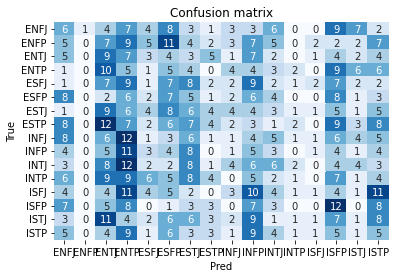

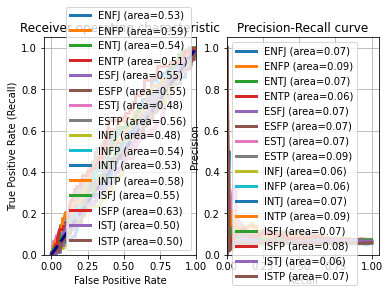

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import seaborn as sns
classes = np.unique(test_cats)

## Plot confusion matrix
cm = metrics.confusion_matrix(test_cats, preds)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()
